In [141]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
from src.SpectralClustering import SpectralClustering
from sklearn.cluster import KMeans
import networkx as nx

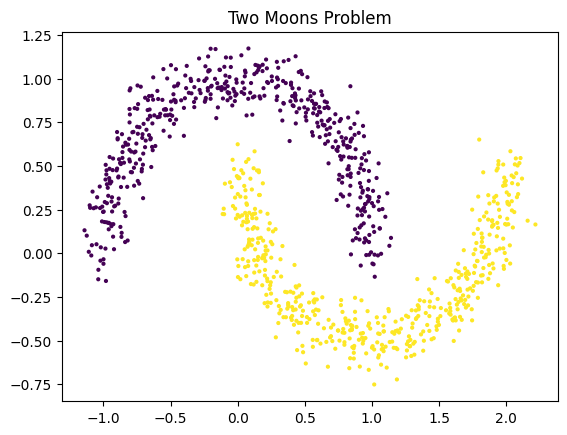

In [181]:
# generate the two moons problem

X, y_true = sklearn.datasets.make_moons(n_samples=1000, shuffle=False, noise=0.09, random_state=42)
plt.scatter(X[:,0], X[:,1], c=y_true, s=4)
plt.title('Two Moons Problem')
plt.show()

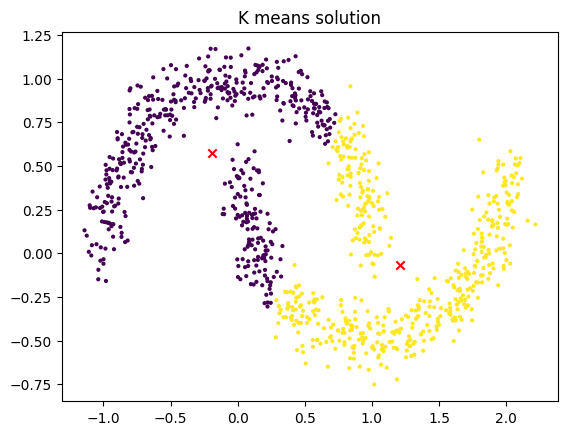

In [204]:
# show the k-means solution

k_means_model = KMeans(n_clusters=2)
k_means_model.fit(X)
y_pred = k_means_model.labels_

plt.scatter(X[:,0], X[:,1], c=y_pred, s=4)
plt.scatter(k_means_model.cluster_centers_[:,0], k_means_model.cluster_centers_[:,1], c='r', marker='x')
plt.title('K means solution')
plt.show()

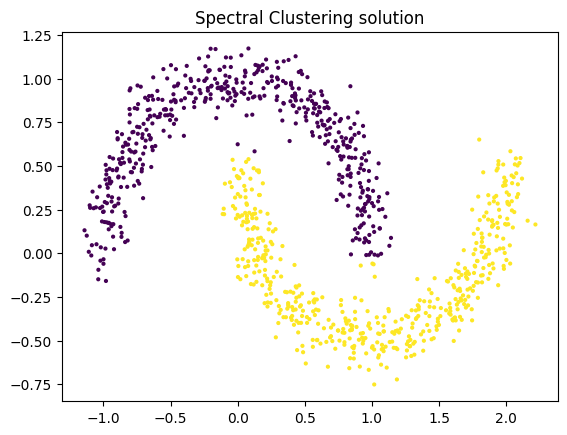

In [183]:
# generate my solution

spec_model = SpectralClustering(2)
spec_model.fit(X)
y_pred = spec_model.labels_

plt.scatter(X[:,0], X[:,1], c=y_pred, s=4)
plt.title('Spectral Clustering solution')
plt.show()

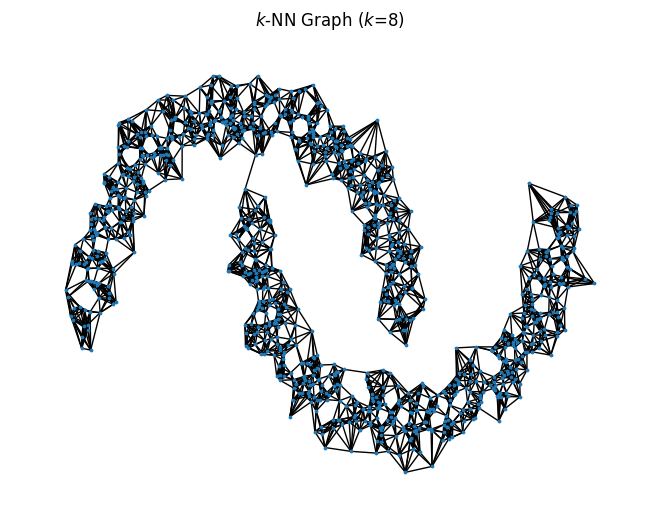

In [199]:
# apply a nearest neighbour algorithm to point cloud

# take a point cloud (num_points, num_dim) and formulate a networkx Graph
def point_cloud_to_graph(points):
    G = nx.Graph()

    # take each row as the position for the point
    points = [(i, {"pos": tuple(x)}) for i, x in enumerate(points)]
    G.add_nodes_from(points)
    return G

def generate_knn_graph(G, x, y , k = None):
    G = nx.create_empty_copy(G)
    N = G.number_of_nodes()

    def gen_knn_grph(G, k):
        edges = []
        for i1 in range(N):
            # calculate distances to other nodes
            x1, y1 = x[i1], y[i1]
            d = np.sqrt(np.square(x - x1) + np.square(y - y1))

            # find k closest other nodes
            idx = np.argpartition(d, k + 1)
            idx = idx[idx != i1]
            idx = idx[:k]

            # create edges to these other nodes
            new_edges = [(i1, other) for other in idx]
            edges.extend(new_edges)
 
        G.add_edges_from(edges)
        return G, k

    if k is not None:
        return gen_knn_grph(G, k)

    k = 1
    while not nx.is_connected(G):
        k += 1
        G = nx.create_empty_copy(G)
        G, _ = gen_knn_grph(G, k)
    return G, k

# apply to our current dataset
G_moons = point_cloud_to_graph(X)
G_k, k = generate_knn_graph(G_moons, X[:,0], X[:,1])

nx.draw(G_k, pos=X, node_size = 3)
plt.title(f"$k$-NN Graph ($k$={k})")
plt.show()

In [200]:
# generate our laplacian matrix
G = G_k
lap = nx.laplacian_matrix(G).todense()
lap


array([[11,  0, -1, ...,  0,  0,  0],
       [ 0,  9,  0, ...,  0,  0,  0],
       [-1,  0, 12, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  9,  0,  0],
       [ 0,  0,  0, ...,  0, 12, -1],
       [ 0,  0,  0, ...,  0, -1, 14]])

In [207]:
# perform eigenecomposition, sort wrt to eigenvalue

eig_val, eig_vec = np.linalg.eig(lap)
eig_val = eig_val.real
eig_vec = eig_vec.real

ordering = eig_val.argsort()
eig_val  = eig_val[  ordering]
eig_vec  = eig_vec[:,ordering]

eig_val[:5]

array([3.22875407e-15, 1.59750126e-03, 7.91744668e-03, 1.04596076e-02,
       3.01326257e-02])

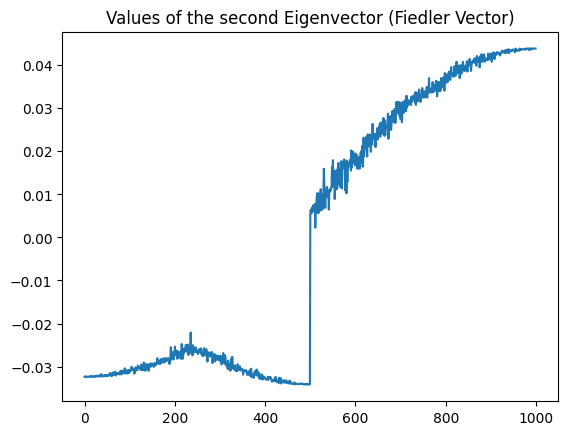

In [202]:
# embedding the new points in the new space given by fiedler vector

embedding = eig_vec[:,[1]]
plt.title('Values of the second Eigenvector (Fiedler Vector)')
plt.plot(embedding[:,0])

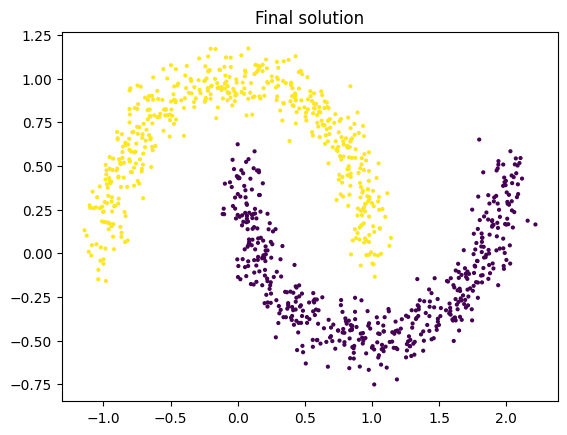

In [203]:
# running a k-means model on the new embedding

kmeans_model = KMeans(2).fit(embedding)
y_pred = kmeans_model.labels_
plt.scatter(X[:,0], X[:,1], c=y_pred, s=4)
plt.title('Final solution')
plt.show()